# MNIST with sklearn

We'll run through MNIST using the sklearn library. Data for this notebook was pulled from:
https://www.kaggle.com/c/digit-recognizer

which at the time contained a set if files encompassing a subset of the MNIST dataset, divided into train/test/submission sets.

In [27]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import sys
import time
import random
import tarfile
from IPython.display import display, Image

from scipy import ndimage
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import linear_model, decomposition, datasets, ensemble

from sklearn.grid_search import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,accuracy_score

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))
# Any results you write to the current directory are saved as output.

datadir=".\\data\\digits_recognizer\\"
# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

##Function definitions

In [3]:
def loadData(filename):
    # Load the wholesale customers dataset
    #data = pd.read_csv(filename)
    try:
        data = pd.read_csv(filename, parse_dates=True)
        #data.drop(['Region', 'Channel'], axis = 1, inplace = True)
        print ("Dataset has {} samples with {} features each.".format(*data.shape))
    except Exception as e:
        print ("Dataset could not be loaded. Is the dataset missing?")
        print(e)
    return data
def writeData(data,filename):
    # Load the wholesale customers dataset
    try:
        data.to_csv(filename, index=False)
    except Exception as e:
        print ("Dataset could not be written.")
        print(e)
    verify=[]
    try:
        with open(filename, 'r') as f:
            for line in f:
                verify.append(line)
        f.closed
        return verify[:5]
    except IOError:
        sys.std

def dispImage(image):
        plt.imshow(image, cmap='binary')
        plt.show()
    
def runPredict(clf,Data, display=True):
    index=random.randrange(len(Data))
    y_pred = clf.predict(Data[index].reshape(1, -1))[0]
    if display==True:
        dispImage(np.reshape(Data[index],(28,28)))
    return y_pred

def train_classifier(clf, X_train, y_train):
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    return end - start
    #print "Done!\nTraining time (secs): {:.3f}".format(end - start)
    
# Predict on training set and compute F1 score
def predict_labels(clf, features, target):
    #print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    #print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return f1_score(target, y_pred,average='micro'),end - start #(None, 'micro', 'macro', 'weighted', 'samples')

# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):

    timeTrain=train_classifier(clf, X_train, y_train)
    predict_train,trainDelta=predict_labels(clf, X_train, y_train)
    predict_test,testDelta=predict_labels(clf, X_test, y_test)
    return predict_test,testDelta,predict_train,trainDelta,timeTrain # let's return the scores, so we can use them for comparisons

#for each data set size run and plot a train/test
def runTests(test_sizes, train_dataset,train_labels,test_dataset,test_labels, clf=""):
    test_f1=[]
    train_f1=[]

    for test_size in test_sizes:
        # Set up the train set for the test size
        X_train=train_dataset[:test_size]
        y_train=train_labels[:test_size]
        # Same for test
        X_test=test_dataset[-test_size:]
        y_test=test_labels[-test_size:]

        # logistic regresion needs some data massaging to work
      #  X_train=X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
      #  X_test=X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])

        if clf == "":
            clf=LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42,  max_iter=1000,C=1e-5)

        # Fit model to training data
        test,testDelta,train,trainDelta,timeTrain = train_predict(clf, X_train, y_train, X_test, y_test)
        test_f1.append(test)
        train_f1.append(train)
        print ("------------------------------------------")
        print ("Training set size: {},".format(len(X_train)),"Train time (secs): {:.3f}".format(timeTrain))
        print ("F1 score for training set: {},".format(train),"Prediction time (secs): {:.3f}".format(trainDelta))
        print ("F1 score for test set: {},".format(test),"Prediction time (secs): {:.3f}".format(testDelta))

    
    print ("\n",clf)
    print("Test F1:{}".format(test_f1))
    display("Train F1:{}".format(train_f1))
    plt.plot(test_f1,label="Test F1")
    plt.plot(train_f1,label="Train F1")
    plt.legend(loc=2)
    plt.title("F1 Score per run")
    plt.show()
    
    return clf    

## Load the Training data
We'll load the training data and take a look at a row, verify features, etc. We'll also display a data point as an image and verify it matches the label

Dataset has 42000 samples with 785 features each.
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0         0  

[1 rows x 785 columns]
('size of each entry', 784)
('for index', 39466, 'label is:', 4)


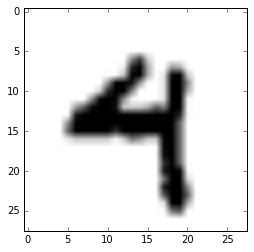

In [15]:
#Load up the train data
trainData=loadData(datadir+"train.csv")
print (trainData.head(1))
y = trainData["label"]
x = trainData.drop("label", axis=1)
#print (y.head(2))
#print (x.head(2))

#print (x.values[5])
print ("size of each entry",len(x.values[5]))

index=random.randrange(len(x))
print("for index",index,"label is:",y.values[index])
dispImage(np.reshape(x.values[index],(28,28)))

## Split the data for train/test, and run training data of various size through the classifier
We use train_test_split, from the sklearn.cross_validation to split the data into a training and validation group. Then we feed this data in various test sizes to a classifier and evaluate the scores. 
Finally, we run a prediction on a random value from the validation set, and visually ensure that it is predicted correctly!

('size of train data', 31500L)
('run tests of size', [63, 630, 6300, 31500])


C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


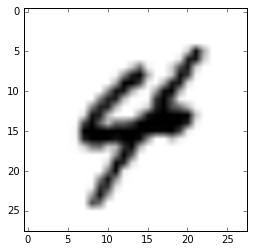

('Validation Prediction is:', 2)
------------------------------------------

C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)



('Training set size: 63,', 'Train time (secs): 3.623')
('F1 score for training set: 0.174603174603,', 'Prediction time (secs): 0.013')
('F1 score for test set: 0.126984126984,', 'Prediction time (secs): 0.000')
------------------------------------------

C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)



('Training set size: 630,', 'Train time (secs): 3.201')
('F1 score for training set: 0.163492063492,', 'Prediction time (secs): 0.008')
('F1 score for test set: 0.157142857143,', 'Prediction time (secs): 0.019')
------------------------------------------

C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)



('Training set size: 6300,', 'Train time (secs): 15.269')
('F1 score for training set: 0.156031746032,', 'Prediction time (secs): 0.049')
('F1 score for test set: 0.172698412698,', 'Prediction time (secs): 0.041')
------------------------------------------
('Training set size: 31500,', 'Train time (secs): 51.971')
('F1 score for training set: 0.172444444444,', 'Prediction time (secs): 0.287')
('F1 score for test set: 0.177142857143,', 'Prediction time (secs): 0.089')
('\n', KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=9, n_init=10,
    n_jobs=-1, precompute_distances='auto', random_state=None, tol=0.001,
    verbose=0))
Test F1:[0.12698412698412698, 0.15714285714285714, 0.17269841269841271, 0.17714285714285713]


C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


'Train F1:[0.17460317460317459, 0.16349206349206349, 0.15603174603174602, 0.17244444444444446]'

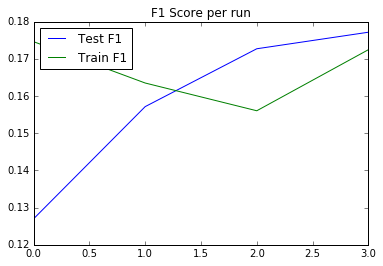

C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


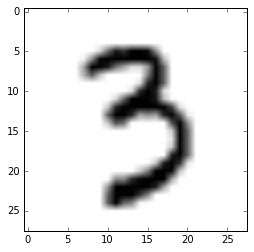

('Validation Prediction is:', 3)
------------------------------------------
('Training set size: 63,', 'Train time (secs): 0.193')
('F1 score for training set: 0.222222222222,', 'Prediction time (secs): 0.016')
('F1 score for test set: 0.111111111111,', 'Prediction time (secs): 0.008')
------------------------------------------
('Training set size: 630,', 'Train time (secs): 0.602')
('F1 score for training set: 0.404761904762,', 'Prediction time (secs): 0.025')
('F1 score for test set: 0.398412698413,', 'Prediction time (secs): 0.025')
------------------------------------------
('Training set size: 6300,', 'Train time (secs): 6.250')
('F1 score for training set: 0.689206349206,', 'Prediction time (secs): 0.248')
('F1 score for test set: 0.683650793651,', 'Prediction time (secs): 0.249')
------------------------------------------
('Training set size: 31500,', 'Train time (secs): 35.674')
('F1 score for training set: 0.733238095238,', 'Prediction time (secs): 1.528')
('F1 score for test 

'Train F1:[0.22222222222222221, 0.40476190476190477, 0.68920634920634916, 0.73323809523809513]'

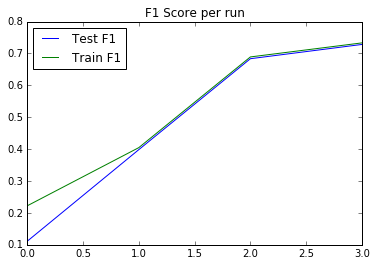

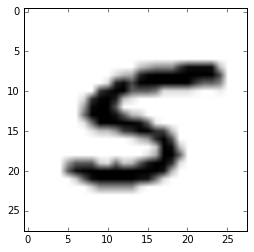

('Validation Prediction is:', 5)
------------------------------------------
('Training set size: 63,', 'Train time (secs): 0.107')
('F1 score for training set: 1.0,', 'Prediction time (secs): 0.001')
('F1 score for test set: 0.809523809524,', 'Prediction time (secs): 0.000')
------------------------------------------
('Training set size: 630,', 'Train time (secs): 0.241')
('F1 score for training set: 1.0,', 'Prediction time (secs): 0.003')
('F1 score for test set: 0.809523809524,', 'Prediction time (secs): 0.002')
------------------------------------------
('Training set size: 6300,', 'Train time (secs): 4.137')
('F1 score for training set: 0.984126984127,', 'Prediction time (secs): 0.022')
('F1 score for test set: 0.848888888889,', 'Prediction time (secs): 0.020')
------------------------------------------
('Training set size: 31500,', 'Train time (secs): 71.991')
('F1 score for training set: 0.876761904762,', 'Prediction time (secs): 0.109')
('F1 score for test set: 0.847714285714,',

'Train F1:[1.0, 1.0, 0.98412698412698407, 0.87676190476190474]'

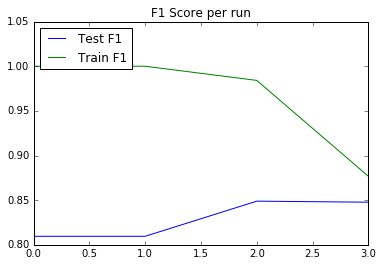

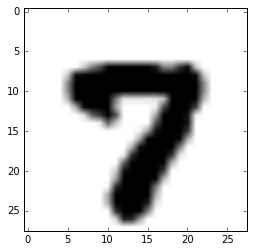

('Validation Prediction is:', 7)


In [28]:
#  train/validation split
X_train, X_test, y_train, y_test = train_test_split( x.values, y.values, test_size=0.25, random_state=42)

dataSize=X_train.shape[0]
print ("size of train data",dataSize)
test_sizes=[50]
for i in range(5):
    test_sizes.append(int(round(dataSize*(i+1)*.2)))

test_sizes=[63,630,6300,31500]
#test_sizes=[50,500,5001]
print ("run tests of size",test_sizes)
#clf=runTests(test_sizes, X_train,y_train,X_test,y_test)

print("Validation Prediction is:",runPredict(clf,X_test))

clf = runTests(test_sizes, X_train,y_train,X_test,y_test, KMeans( n_jobs=-1, n_clusters=9, tol = 0.001))
print("Validation Prediction is:",runPredict(clf,X_test))

clf = runTests(test_sizes, X_train,y_train,X_test,y_test,ensemble.AdaBoostClassifier())
print("Validation Prediction is:",runPredict(clf,X_test))

clf = runTests(test_sizes, X_train,y_train,X_test,y_test,LinearSVC(class_weight="balanced"))
print("Validation Prediction is:",runPredict(clf,X_test))


## test data, 
Now, we load the test data and make sure that it also can be used to make a prediction. the output should be correctly predicted or at least reasonably close!

Test Data:
Dataset has 28000 samples with 784 features each.


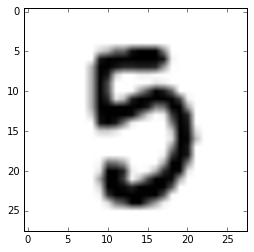

('Test Set Prediction is:', 5)


In [17]:
#loadup the  test data
print ("Test Data:")
testData=loadData(datadir+"test.csv") # no need to load this yet!print (testData)

#testData = np.array(testData).reshape((len(testData), -1))

print("Test Set Prediction is:",runPredict(clf,testData.values))

## Prep submission 
make a prediction for each test data point, and store. As we proceed throught the data, we check in to make sure that everything still is being predicted correctly!

('run:', 0, 'entry#:', 1, 'predicted:', 2)


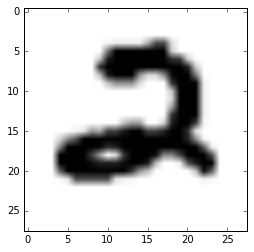

('run:', 5000, 'entry#:', 5001, 'predicted:', 1)


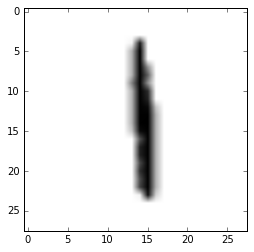

('run:', 10000, 'entry#:', 10001, 'predicted:', 0)


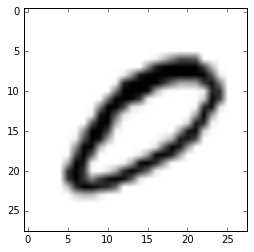

('run:', 15000, 'entry#:', 15001, 'predicted:', 5)


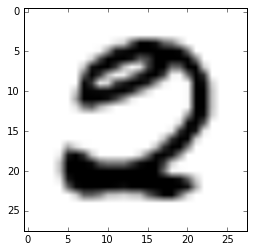

('run:', 20000, 'entry#:', 20001, 'predicted:', 7)


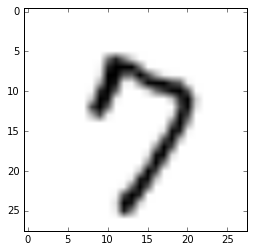

('run:', 25000, 'entry#:', 25001, 'predicted:', 2)


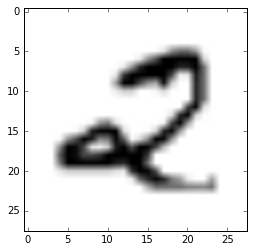

('size of submission', 28000)


In [18]:

submission =[]
for index in range(len(testData.values)):
    submission.append((index+1,clf.predict(testData.values[index].reshape(1, -1))[0]))
    if index%5000 == 0:
        print("run:",index,"entry#:",submission[index][0], "predicted:",submission[index][1])
        dispImage(np.reshape(testData.values[index],(28,28)))
        
print ("size of submission",len(submission))



## submission

write the data to a csv for submission!

In [19]:
#Write our the data for submission
verify=writeData(pd.DataFrame(submission,columns=["ImageId","Label"]),'digitrecognizer-submission.csv')
print(verify)

['ImageId,Label\n', '1,2\n', '2,0\n', '3,9\n', '4,7\n']


## Conclusions...

regular statistical machine learning methods, via sklearn may be used to make a very successful prediction, but may not be up to the current state of the art. Deep learning methods, particularly a convolutional neural net, such as leCun or the inception net may perform better 

###EOF